# 1. Importacion de librerias y analisis de datos

In [ ]:
import pandas as pd 
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import joblib
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import mean_absolute_error, mean_squared_error



In [2]:
crypto_info = pd.read_csv("Crypto_historical_data.csv")

In [3]:
crypto_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 346260 entries, 0 to 346259
Data columns (total 8 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Date    346260 non-null  object 
 1   Open    344915 non-null  float64
 2   High    344915 non-null  float64
 3   Low     344915 non-null  float64
 4   Close   346260 non-null  float64
 5   Volume  346260 non-null  int64  
 6   ticker  346260 non-null  object 
 7   name    346260 non-null  object 
dtypes: float64(4), int64(1), object(3)
memory usage: 21.1+ MB


In [4]:
crypto_info.head(10)

,Date,Open,High,Low,Close,Volume,ticker,name
0,2020-04-10 00:00:00+00:00,0.832005,1.313487,0.694187,0.951054,87364276,SOL-USD,Solana
1,2020-04-11 00:00:00+00:00,0.951054,1.049073,0.765020,0.776819,43862444,SOL-USD,Solana
2,2020-04-12 00:00:00+00:00,0.785448,0.956670,0.762426,0.882507,38736897,SOL-USD,Solana
3,2020-04-13 00:00:00+00:00,0.890760,0.891603,0.773976,0.777832,18211285,SOL-USD,Solana
4,2020-04-14 00:00:00+00:00,0.777832,0.796472,0.628169,0.661925,16747614,SOL-USD,Solana
5,2020-04-15 00:00:00+00:00,0.669289,0.704964,0.621531,0.646651,13075275,SOL-USD,Solana
6,2020-04-16 00:00:00+00:00,0.630879,0.774192,0.625107,0.690816,21346031,SOL-USD,Solana
7,2020-04-17 00:00:00+00:00,0.689312,0.719614,0.660728,0.660728,9870810,SOL-USD,Solana
8,2020-04-18 00:00:00+00:00,0.660728,0.717618,0.659427,0.681096,9782112,SOL-USD,Solana
9,2020-04-19 00:00:00+00:00,0.681516,0.684641,0.598487,0.606969,9289670,SOL-USD,Solana


In [6]:
crypto_info.isna().sum()

Date         0
Open      1345
High      1345
Low       1345
Close        0
Volume       0
ticker       0
name         0
dtype: int64

In [7]:
crypto_info.duplicated().sum()

np.int64(0)

Podemos ver datos ausentes que posiblemente nos puedan afectar la creacion de un modelo predictivo del precio de algunas cryptomonedas, estos datos se podrian completar mediante un metodo de imputacion basada en modelo de vecinos mas cercanos ya que dichos valores ausentes pocas veces se alejan entre si.

Pero como vamos a crear un modelo a partir de un tipo de moneda especifica como el Ethereum es posible que no tengamos que hacer dicho procedimiento.

In [8]:
eth_data = crypto_info[crypto_info['name'] == 'Ethereum']

In [9]:
eth_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2926 entries, 7562 to 10487
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    2926 non-null   object 
 1   Open    2926 non-null   float64
 2   High    2926 non-null   float64
 3   Low     2926 non-null   float64
 4   Close   2926 non-null   float64
 5   Volume  2926 non-null   int64  
 6   ticker  2926 non-null   object 
 7   name    2926 non-null   object 
dtypes: float64(4), int64(1), object(3)
memory usage: 205.7+ KB


Podemos ver que en el caso de Ethereum no se encuentran datos ausentes y sabemos que no hay datos duplicados por lo que podremos crear un modelo sin problemas, pero antes cambiaremos los datos de object a datetime en las fechas y aunque parecen estar ordenadas lo ordenaremos por fechas

In [10]:
eth_data['Date'] = pd.to_datetime(eth_data['Date'])


C:\Users\sergi\AppData\Local\Temp\ipykernel_15972\1000442203.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  eth_data['Date'] = pd.to_datetime(eth_data['Date'])


In [11]:
eth_data = eth_data.sort_values('Date')


In [14]:
eth_data.info()


<class 'pandas.core.frame.DataFrame'>
Index: 2926 entries, 7562 to 10487
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype              
---  ------  --------------  -----              
 0   Date    2926 non-null   datetime64[ns, UTC]
 1   Open    2926 non-null   float64            
 2   High    2926 non-null   float64            
 3   Low     2926 non-null   float64            
 4   Close   2926 non-null   float64            
 5   Volume  2926 non-null   int64              
 6   ticker  2926 non-null   object             
 7   name    2926 non-null   object             
dtypes: datetime64[ns, UTC](1), float64(4), int64(1), object(2)
memory usage: 205.7+ KB


In [13]:
eth_data.head()


,Date,Open,High,Low,Close,Volume,ticker,name
7562,2017-11-09 00:00:00+00:00,308.644989,329.451996,307.056000,320.884003,893249984,ETH-USD,Ethereum
7563,2017-11-10 00:00:00+00:00,320.670990,324.717987,294.541992,299.252991,885985984,ETH-USD,Ethereum
7564,2017-11-11 00:00:00+00:00,298.585999,319.453003,298.191986,314.681000,842300992,ETH-USD,Ethereum
7565,2017-11-12 00:00:00+00:00,314.690002,319.153015,298.513000,307.907990,1613479936,ETH-USD,Ethereum
7566,2017-11-13 00:00:00+00:00,307.024994,328.415009,307.024994,316.716003,1041889984,ETH-USD,Ethereum


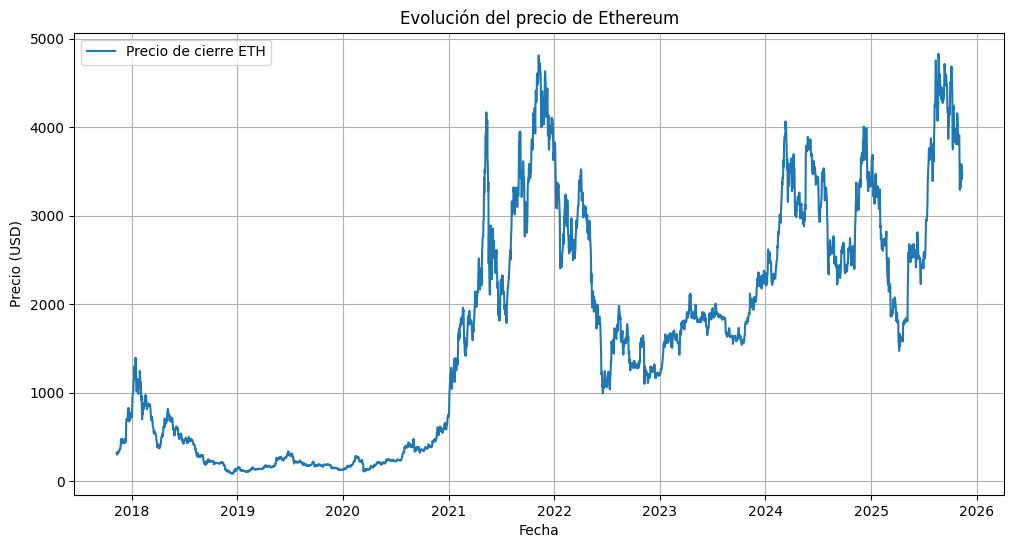

In [17]:
plt.figure(figsize=(12,6))
plt.plot(eth_data['Date'], eth_data['Close'], label='Precio de cierre ETH')
plt.xlabel('Fecha')
plt.ylabel('Precio (USD)')
plt.title('Evolución del precio de Ethereum')
plt.legend()
plt.grid(True)
plt.show()

Se puede observar claramente cómo el precio de cierre de Ethereum ha tenido una evolución significativa desde 2018 hasta 2025, con varios picos notables, especialmente entre 2021 y 2022, y una alta volatilidad en los años posteriores.

# 2. Preprocesamiento de datos

Normalizacion de datos: transforma los datos para que estén entre 0 y 1.

In [19]:
# Seleccionar las columnas numéricas que quieres escalar
features_to_scale = ['Open', 'High', 'Low', 'Close', 'Volume']

# Crear el escalador
scaler = MinMaxScaler()

# Aplicar el escalado
eth_scaled = eth_data.copy()
eth_scaled[features_to_scale] = scaler.fit_transform(eth_scaled[features_to_scale])


In [20]:
eth_scaled[features_to_scale].describe()

,Open,High,Low,Close,Volume
count,2926.000000,2926.000000,2926.000000,2926.000000,2926.000000
mean,0.332300,0.333090,0.329975,0.332475,0.145500
std,0.272850,0.272982,0.271410,0.272834,0.126000
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.053277,0.054129,0.052585,0.053360,0.057487
50%,0.325604,0.323217,0.324610,0.325775,0.117075
75%,0.534210,0.536014,0.532482,0.534458,0.193697
max,1.000000,1.000000,1.000000,1.000000,1.000000


Es importante guardar el objeto scaler para poder revertir la transformación después de hacer predicciones

In [ ]:
joblib.dump(scaler, 'eth_scaler.pkl')

['eth_scaler.pkl']

Ya que los datos están limpios y escalados, el siguiente paso es crear secuencias temporales para alimentar el modelo

Creacion de ventanas de tiempo

In [24]:
# Usaremos solo la columna 'Close' para predecir
data = eth_scaled['Close'].values

# Definir tamaño de la ventana (por ejemplo, 60 días)
window_size = 60

X = []
y = []

for i in range(window_size, len(data)):
    X.append(data[i-window_size:i])
    y.append(data[i])

# Convertir a arrays numpy
X, y = np.array(X), np.array(y)

# Redimensionar para LSTM: [samples, time steps, features]
X = np.reshape(X, (X.shape[0], X.shape[1], 1))


Dividir datos en entrenamiento y prueba

In [25]:
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]


# 3. Creacion de Modelo

Definir el modelo LSTM

In [27]:
model = Sequential()

# Capa LSTM con 50 unidades
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))

# Segunda capa LSTM
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))

# Capa de salida
model.add(Dense(units=1))  # Predicción del precio

# Compilar el modelo
model.compile(optimizer='adam', loss='mean_squared_error')


c:\Users\sergi\VSCode SM\modelo predictivo cripto\crypto_ent\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Entrenamiento de modelo

In [28]:
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 10s 89ms/step - loss: 0.0097 - val_loss: 0.0043
Epoch 2/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 6s 81ms/step - loss: 0.0027 - val_loss: 0.0029
Epoch 3/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 5s 73ms/step - loss: 0.0023 - val_loss: 0.0025
Epoch 4/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 0.0022 - val_loss: 0.0024
Epoch 5/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 0.0020 - val_loss: 0.0023
Epoch 6/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 0.0020 - val_loss: 0.0020
Epoch 7/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 0.0018 - val_loss: 0.0019
Epoch 8/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 0.0018 - val_loss: 0.0018
Epoch 9/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 0.0015 - val_loss: 0.0018
Epoch 10/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 0.0016 - val_loss: 0.0021
Epoch 11/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 0.0015 - val_loss: 0.0016
Epoch 12/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 0.

Análisis del entrenamiento
- Pérdida de entrenamiento (loss): bajó de 0.0097 a ~0.0008, lo que indica que el modelo está ajustando bien los datos.
- Pérdida de validación (val_loss): también disminuyó, alcanzando mínimos cercanos a 0.00079, lo que sugiere buena capacidad de generalización.
- Hay algunas fluctuaciones en val_loss, pero no hay señales claras de sobreajuste. El modelo se mantiene estable.


Prediccion y Visualizacion

In [29]:
predicted_prices = model.predict(X_test)

18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step


Invertir el escalado para ver precios reales

In [34]:
# Crear arrays con ceros para las otras columnas
padding = np.zeros((predicted_prices.shape[0], 4))

# Concatenar y aplicar inverse_transform
predicted_unscaled = scaler.inverse_transform(np.hstack((padding, predicted_prices)))[:, -1]
real_unscaled = scaler.inverse_transform(np.hstack((padding, y_test.reshape(-1, 1))))[:, -1]



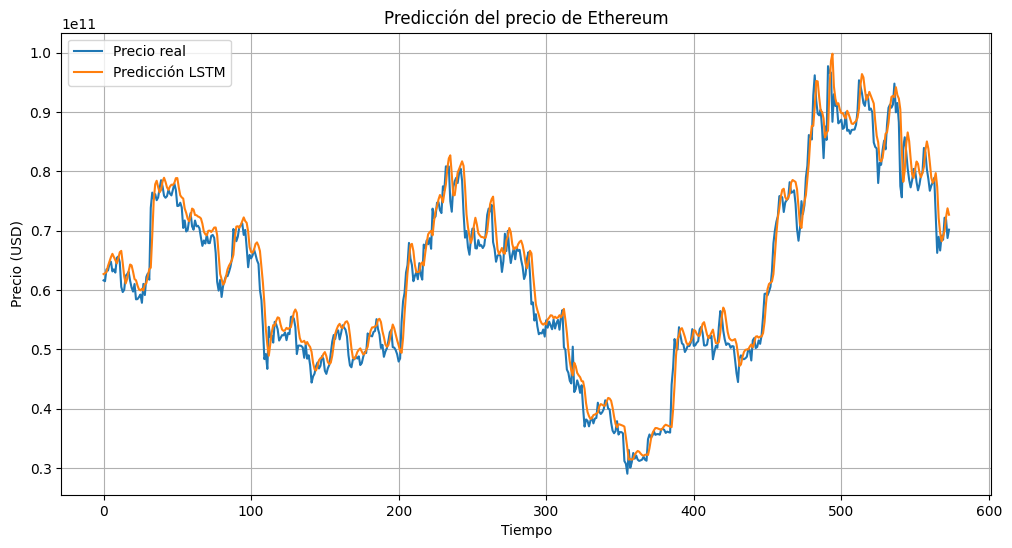

In [35]:
plt.figure(figsize=(12,6))
plt.plot(real_unscaled, label='Precio real')
plt.plot(predicted_unscaled, label='Predicción LSTM')
plt.title('Predicción del precio de Ethereum')
plt.xlabel('Tiempo')
plt.ylabel('Precio (USD)')
plt.legend()
plt.grid(True)
plt.show()

Las predicciones del modelo estan muy crecanas a los valores originales, pero para ver que tan preciso es el modelo vamos a calcular las metricas de evaluacion

In [41]:
mae = mean_absolute_error(real_unscaled, predicted_unscaled)
rmse = np.sqrt(mean_squared_error(real_unscaled, predicted_unscaled))

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")



MAE: 2242550773.17
RMSE: 3005510035.47


El MAE nos muestra que en promedio el modelo se equivoca por más de 2.24 mil millones de dólares por predicción. Y el RMSE nos muestra que el error típico está en el rango de 3 mil millones de dólares. Esto puede ser porque hubo un problema en el escalado inverso. Es probable que al aplicar inverse_transform, se hayan incluido columnas con ceros o valores irrelevantes, lo que distorsionó el resultado.
 

Por lo que se hara un ajuste del escalador para ver si hay mejora en las metricas de evaluacion


In [42]:
# Ajustar el escalador solo con la columna original 'Close'
close_scaler = MinMaxScaler()
close_scaler.fit(eth_data[['Close']])

# Revertir predicciones y valores reales
predicted_unscaled = close_scaler.inverse_transform(predicted_prices)
real_unscaled = close_scaler.inverse_transform(y_test.reshape(-1, 1))


In [43]:
mae = mean_absolute_error(real_unscaled, predicted_unscaled)
rmse = np.sqrt(mean_squared_error(real_unscaled, predicted_unscaled))

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")


MAE: 109.62
RMSE: 146.91


Efectivamente estos valores son bastante aceptables para una serie temporal de criptomonedas, especialmente considerando su alta volatilidad. Si el precio de Ethereum está en el rango de cientos o miles de dólares, un error de ~100 USD puede ser tolerable dependiendo del objetivo del modelo (trading, análisis, alertas, etc.).

El modelo podria mejorar mas realizando las siguientes acciones:
- Probar con más capas o unidades LSTM.
- Ajustar el tamaño de la ventana temporal (window_size).
- Usar técnicas como EarlyStopping o regularización.

O se podria utilizar otro tipo de modelos como Random Forest o XGBoost: agregando características derivadas (SMA, RSI, etc.)
